In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm

In [22]:
import torch, os, random
import torch.nn as nn
import timm

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class Classifier(nn.Module):
    def __init__(self, model, num_classes=2):
        super().__init__()
        self.model = model
        self.classifier = nn.Linear(hidden_size, num_classes)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x # self.sigmoid(x)

In [36]:
model_name = 'inception_v4' # inception_v4 inception_resnet_v2
hidden_size = 768
pretrained = False
model = timm.create_model(model_name, pretrained=pretrained, num_classes=2)

In [25]:
classifier = Classifier(model, num_classes=6).to(device)

In [37]:
dict_file = '/content/drive/MyDrive/CV_project/skin_model/binary_inception_v4.pt'

In [39]:
pretrained = torch.load(dict_file)

state_dict = pretrained['state_dict']
labels = pretrained['label']

model_dict = model.state_dict()
model_dict.update(state_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [40]:
labels

['무증상', '유증상']

# to .onnx

In [9]:
import torch.onnx

In [ ]:
classifier = model.to(device)
classifier.eval()

In [16]:
model_path = '/content/drive/MyDrive/CV_project/skin_model'

In [42]:
torch_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(classifier, torch_input, os.path.join(model_path, 'binary_inception_v4.onnx'))

# onnx inference

In [93]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 15.4 MB/s eta 0:00:00


In [46]:
import onnxruntime
from scipy.special import softmax
from PIL import Image
from torchvision.transforms import ToTensor

In [43]:
labels

['무증상', '유증상']

In [44]:
model_path = '/content/drive/MyDrive/CV_project/skin_model'

In [47]:
filepath = os.path.join(model_path, 'binary_inception_v4.onnx')
ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name

In [ ]:
labels

In [56]:
def inference(img_path, labels):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    result_dict = {}

    for i, value in enumerate(result[0][0].tolist()):
        result_dict[labels[i]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [103]:
def inference_simple(img_path):

    img = Image.open(img_path)
    img = img.resize((224, 224))
    img = ToTensor()(img).unsqueeze(0)

    ort_inputs = {input_name: img.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)

    result = softmax(ort_outs)
    return (result[0][0].argmax(), result[0][0].tolist())

In [104]:
root = '/content/drive/MyDrive/CV_project/data/SKIN/test/test_dog_resized'

In [107]:
predictions = {'target':[], 'pred':[], 'probs':[]}
for folder in os.listdir(root):
    print(folder, len(os.listdir(os.path.join(root, folder))))
    for file in os.listdir(os.path.join(root, folder)):
        if folder.startswith('A'):
            predictions['target'].append(1)
        else:
            predictions['target'].append(0)
        inf_result = inference_simple(os.path.join(root, folder, file))
        predictions['pred'].append(inf_result[0])
        predictions['probs'].append(inf_result[1])
        if len(predictions['pred']) % 1000 == 0:
            print(len(predictions['pred']), "done")

A1_구진_플라크 4068
1000 done
2000 done
3000 done
4000 done
무증상 17401
5000 done
6000 done
7000 done
8000 done
9000 done
10000 done
11000 done
12000 done
13000 done
14000 done
15000 done
16000 done
17000 done
18000 done
19000 done
20000 done
21000 done
A2_비듬_각질_상피성잔고리 7849
22000 done
23000 done
24000 done
25000 done
26000 done
27000 done
28000 done
29000 done
A3_태선화_과다색소침착 6746
30000 done
31000 done
32000 done
33000 done
34000 done
35000 done
36000 done
A4_농포_여드름 1668
37000 done
A5_미란_궤양 1500
38000 done
39000 done
A6_결절_종괴 1514
40000 done


In [108]:
preds = list(map(int, predictions['pred']))
predictions['pred'] = preds

import json

with open('/content/drive/MyDrive/CV_project/skin_model/prediction/binary-inceptionv4-epoch10.json', 'w') as f:
    json.dump(predictions, f)

In [109]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

[Text(0, 0.5, '무증상'), Text(0, 1.5, '유증상')]

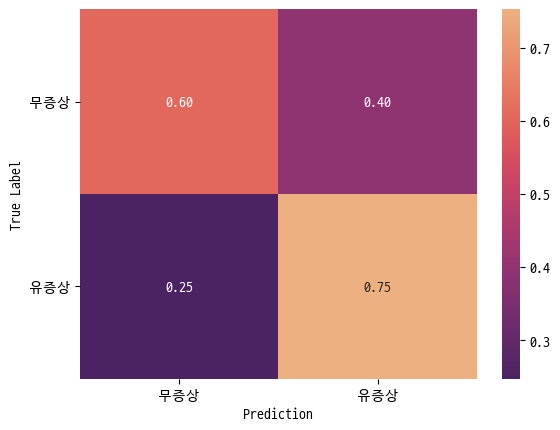

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(predictions['target'], predictions['pred'], normalize='true')
hm = sns.heatmap(cm, annot=True, fmt='.2f', cmap='flare_r')
hm.set_xlabel('Prediction', fontsize=10)
hm.set_ylabel('True Label', fontsize=10)
hm.set_xticklabels(labels=labels, fontsize=10)
hm.set_yticklabels(labels=labels, fontsize=10, rotation=0)

In [111]:
from sklearn.metrics import classification_report

cr = classification_report(predictions['target'], predictions['pred'])
print(cr)

              precision    recall  f1-score   support

           0       0.65      0.60      0.62     17401
           1       0.72      0.75      0.74     23345

    accuracy                           0.69     40746
   macro avg       0.68      0.68      0.68     40746
weighted avg       0.69      0.69      0.69     40746



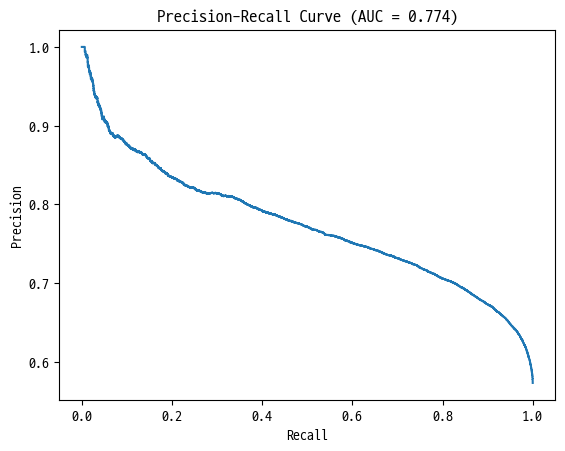

In [113]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import numpy as np

target = np.array(predictions['target'])
probs = np.array(predictions['probs'])[:, 1]

precision, recall, thresholds = precision_recall_curve(target, probs)
pr_auc = auc(recall, precision)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve (AUC = ' + str(round(pr_auc,4)) + ')')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()